## 7. Implement boosting and bagging with your choice of base models and explain all the steps 20

<h2 style="color:green"> TODO: find if the code below works well</h2>
<h2 style="color:green"> TODO: find if which code to use</h2>
<h2 style="color:green"> TODO: improve code</h2>
<h2 style="color:green"> TODO: write explanation (can combine from markdown cells below)</h2>

Bagging builds many independent trees and averages them (reducing variance),
while Boosting builds trees sequentially, each correcting the last (reducing bias).
Visualizing confusion matrices and feature importances reveals how they predict and why they differ.

🔹 Bagging (Bootstrap Aggregation)

Goal: Reduce variance and avoid overfitting.

How: Train many independent models (often of the same type, like Decision Trees) on different random subsets of the data (sampled with replacement), then aggregate (average/vote) their predictions.

Typical model: RandomForestClassifier (which is actually an ensemble of bagged decision trees).

🔹 Boosting

Goal: Reduce both bias and variance by sequentially training weak learners (e.g., shallow trees).

Each model focuses on the mistakes of the previous ones, gradually improving performance.

Typical models: AdaBoostClassifier, GradientBoostingClassifier, and XGBClassifier.

In [ ]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

def get_model_and_params(model_type):
    if model_type == "random_forest":
        model = RandomForestClassifier()
        param_grid = {
            'model__n_estimators': [50, 100],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }

    
    elif model_type == "svm":
        from sklearn.svm import SVC
        model = SVC()
        param_grid = {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }

    # XGBM
    elif model_type == "xgboost":
        model = XGBClassifier(eval_metric='mlogloss')
        param_grid = {
            'model__n_estimators': [50, 100],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.01, 0.1]
        }

    # 🧩 Fixed Bagging
    elif model_type == "bagging":
        base_estimator = DecisionTreeClassifier()
        model = BaggingClassifier(estimator=base_estimator)
        param_grid = {
            'model__n_estimators': [10, 50, 100], # trains multiple decision trees
            'model__estimator__max_depth': [3, 5, 7], # Each tree can have a different
            'model__max_samples': [0.5, 0.8, 1.0], # Each tree uses a subset of data (max_samples)
            'model__max_features': [0.5, 0.8, 1.0] #  and features (max_features)
        }

    # ⚡ Fixed Boosting
    elif model_type == "boosting":
        base_estimator = DecisionTreeClassifier(max_depth=1)
        model = AdaBoostClassifier(estimator=base_estimator)
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 1.0] # controls how much each weak learner contributes
        }

    else:
        raise ValueError("❌ Unknown model type")

    return model, param_grid


In [ ]:
def run_pipeline(data: pd.DataFrame, target_column: str, model_type: str):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model, param_grid = get_model_and_params(model_type)

    if model_type in ["svm"]:
        steps = [('scaler', StandardScaler()), ('model', model)]
    else:
        steps = [('model', model)]
    pipeline = Pipeline(steps)

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"✅ Best parameters for {model_type}:", grid_search.best_params_)
    print(f"📊 Test accuracy ({model_type}):", acc)
    return best_model


<h2 style="color: red;background-color:gold;"> Warning: this cell takes a long time to run (~15 min)</h2>

In [ ]:
# Load your student data
df_my_data = pd.read_csv("./student-graduation/graduation_dataset_processed.csv")

# Example with Bagging
bagging_model = run_pipeline(df_my_data, target_column='Target', model_type='bagging')

# Example with Boosting
boosting_model = run_pipeline(df_my_data, target_column='Target', model_type='boosting')


✅ Best parameters for bagging: {'model__estimator__max_depth': 7, 'model__max_features': 0.5, 'model__max_samples': 0.8, 'model__n_estimators': 100}
📊 Test accuracy (bagging): 0.6700564971751413
✅ Best parameters for boosting: {'model__learning_rate': 1.0, 'model__n_estimators': 200}
📊 Test accuracy (boosting): 0.6983050847457627


Runtime: 17m 53.6s\

Inputs\
cv=5\
Baggings grid:\
'model__n_estimators': [10, 50, 100],  # 3\
'model__estimator__max_depth': [3, 5, 7],  # 3\
'model__max_samples': [0.5, 0.8, 1.0],  # 3\
'model__max_features': [0.5, 0.8, 1.0]  # 3

---

✅ Best parameters for bagging: {'model__estimator__max_depth': 7, 'model__max_features': 0.5,'model__max_samples': 0.8, 'model__n_estimators': 100}\
📊 Test accuracy (bagging): 0.6700564971751413\
✅ Best parameters for boosting: {'model__learning_rate': 1.0, 'model__n_estimators': 200}\
📊 Test accuracy (boosting): 0.6983050847457627

Bagging

model__n_estimators=100 → the best model used 100 decision trees.

model__estimator__max_depth=7 → each tree was allowed to grow to depth 7.
→ Not too shallow, not too deep → moderate model complexity.

model__max_samples=0.8 → each tree trained on 80% of the data (bootstrapped sample).

model__max_features=0.5 → each tree used half of the features, reducing correlation between trees.

✅ Interpretation:
The grid search found that medium-depth trees (7) trained on diverse subsets of your data generalize best.
This helps reduce overfitting but keeps decent predictive power.

---
Boosting

model__n_estimators=200 → The model performed best with 200 weak learners (trees).
→ More iterations gave better accuracy (boosting keeps improving until diminishing returns).

model__learning_rate=1.0 → Large learning rate.
→ Each new tree makes a strong correction for the previous errors.
→ In your dataset, a stronger correction seems to help — suggesting your model might benefit from fewer but stronger trees.

✅ Interpretation:
Boosting found that many strong corrections (high learning rate, many trees) give best results — likely because your dataset is not extremely large or noisy, and a higher rate helps the model converge quickly.

---
What the accuracy tells us

Bagging accuracy = 0.67 (67%)

Boosting accuracy = 0.70 (70%)

✅ Boosting outperforms Bagging by about 3 percentage points, meaning:

Boosting learned more complex decision boundaries by focusing on the misclassified students.

It’s doing a better job identifying patterns that differentiate “dropout,” “extended enrollment,” and “success” cases.

However:

Both scores (0.67–0.70) are moderate.

This suggests your model captures some meaningful signal, but there’s still room for improvement (data or features).
Possible Reasons for Accuracy Around 0.7

Imbalanced classes
If “dropout,” “extended,” and “success” are not equally represented, accuracy may look lower because the model predicts majority classes better.
→ Try checking y.value_counts() to see class distribution.

Feature quality
If features aren’t very predictive (e.g., only basic demographic data), models can only do so much.

Limited feature engineering
Derived features like GPA improvement, attendance ratio, or subject-specific grades often help boost predictive accuracy.

Noise or missing data
If some input features have missing or inconsistent values, performance can degrade.

Try Gradient Boosting or XGBoost

You already used AdaBoost (a simple boosting algorithm).
More advanced versions like XGBoost, LightGBM, or CatBoost typically outperform AdaBoost, often by 5–10% accuracy.

Improve feature engineering

Examples for your dataset:

Combine semester performance into a “trend” feature (improving vs declining)

Encode categorical socio-economic data (e.g. parent education, income)

Normalize attendance rates or prior GPA changes

These features usually improve early student success prediction.

Optional: Ensemble several models

Once you’ve tuned Bagging, Boosting, and RandomForest, you can combine them in a VotingClassifier to leverage all their strengths.

📦 Bagging Accuracy: 0.688
⚡ Boosting Accuracy: 0.663

--- Bagging Report ---
              precision    recall  f1-score   support

     Dropout       0.73      0.66      0.69       284
    Enrolled       0.61      0.13      0.21       159
    Graduate       0.68      0.91      0.77       442

    accuracy                           0.69       885
   macro avg       0.67      0.56      0.56       885
weighted avg       0.68      0.69      0.65       885


--- Boosting Report ---
              precision    recall  f1-score   support

     Dropout       0.74      0.63      0.68       284
    Enrolled       0.32      0.22      0.26       159
    Graduate       0.70      0.84      0.76       442

    accuracy                           0.66       885
   macro avg       0.59      0.57      0.57       885
weighted avg       0.64      0.66      0.65       885



c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


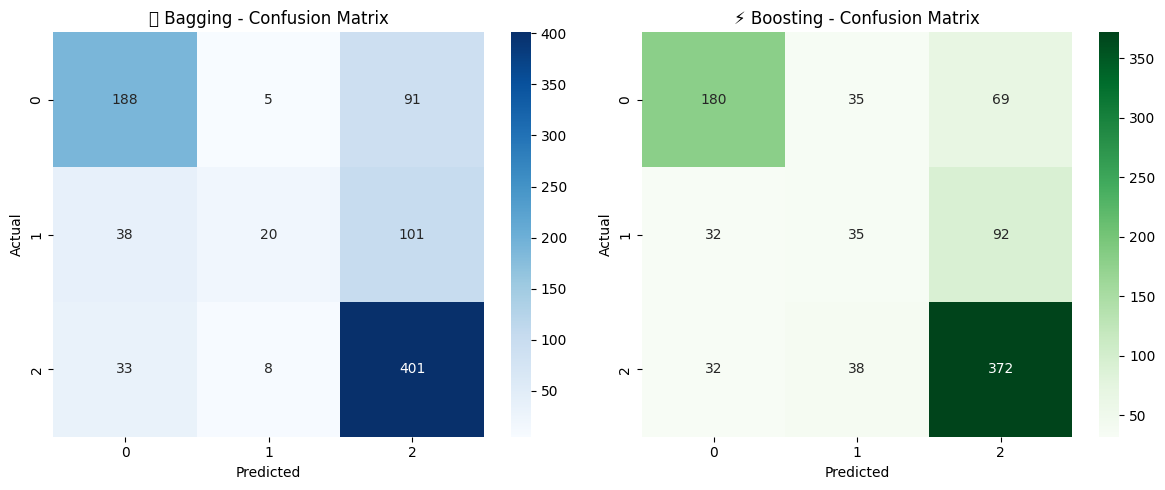

C:\Users\williaht\AppData\Local\Temp\ipykernel_14076\2008703106.py:107: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


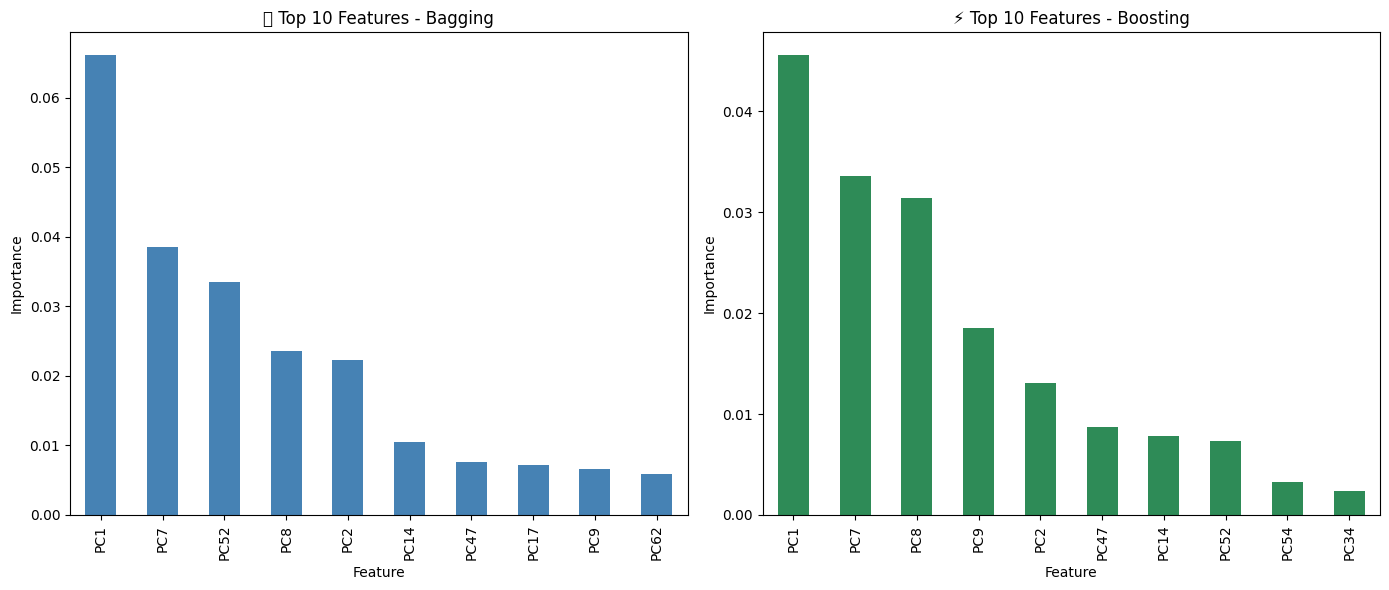

In [21]:
# 1️⃣ Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

# 2️⃣ Load and prepare data
df = pd.read_csv("./student-graduation/graduation_dataset_processed.csv")

X = df.drop(columns=["Target"])
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️⃣ Define ensemble models

## Bagging
bagging_base = DecisionTreeClassifier(random_state=42)
bagging = BaggingClassifier(
    estimator=bagging_base,
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

## Boosting
boosting_base = DecisionTreeClassifier(max_depth=1, random_state=42)
boosting = AdaBoostClassifier(
    estimator=boosting_base,
    n_estimators=200,
    learning_rate=1.0,
    random_state=42
)

# 4️⃣ Train models
bagging.fit(X_train, y_train)
boosting.fit(X_train, y_train)

# 5️⃣ Predictions
y_pred_bagging = bagging.predict(X_test)
y_pred_boosting = boosting.predict(X_test)

# 6️⃣ Accuracy
acc_bagging = accuracy_score(y_test, y_pred_bagging)
acc_boosting = accuracy_score(y_test, y_pred_boosting)

print(f"📦 Bagging Accuracy: {acc_bagging:.3f}")
print(f"⚡ Boosting Accuracy: {acc_boosting:.3f}")

# 7️⃣ Classification reports
print("\n--- Bagging Report ---")
print(classification_report(y_test, y_pred_bagging))
print("\n--- Boosting Report ---")
print(classification_report(y_test, y_pred_boosting))

# 8️⃣ Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_bag = confusion_matrix(y_test, y_pred_bagging)
cm_boost = confusion_matrix(y_test, y_pred_boosting)

sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('📦 Bagging - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_boost, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('⚡ Boosting - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 9️⃣ Feature Importance (Permutation)
bagging_perm = permutation_importance(
    bagging, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
boosting_perm = permutation_importance(
    boosting, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Bagging Importance': bagging_perm.importances_mean,
    'Boosting Importance': boosting_perm.importances_mean
}).set_index('Feature')

# Plot top 10 features for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
feat_imp['Bagging Importance'].sort_values(ascending=False).head(10).plot.bar(ax=axes[0], color='steelblue')
axes[0].set_title('📦 Top 10 Features - Bagging')
axes[0].set_ylabel('Importance')

feat_imp['Boosting Importance'].sort_values(ascending=False).head(10).plot.bar(ax=axes[1], color='seagreen')
axes[1].set_title('⚡ Top 10 Features - Boosting')
axes[1].set_ylabel('Importance')

plt.tight_layout()
plt.show()


Features of the workflow below:

- Bagging and Boosting models with Decision Trees.

- Train/Test Accuracy and Cross-Validation for robust evaluation.

- Confusion Matrices to visualize classification errors.
 
- ROC Curves and AUC for binary classification.

- Permutation Feature Importance for understanding predictors.

- Partial Dependence Plots (PDP) for feature effect visualization.

- SHAP values for detailed interpretability (optional).

📦 Bagging - Train Accuracy: 1.000, Test Accuracy: 0.688
⚡ Boosting - Train Accuracy: 0.742, Test Accuracy: 0.663
Bagging CV Accuracy: 0.688 ± 0.008
Boosting CV Accuracy: 0.684 ± 0.005

--- Bagging Report ---
              precision    recall  f1-score   support

     Dropout       0.73      0.66      0.69       284
    Enrolled       0.61      0.13      0.21       159
    Graduate       0.68      0.91      0.77       442

    accuracy                           0.69       885
   macro avg       0.67      0.56      0.56       885
weighted avg       0.68      0.69      0.65       885


--- Boosting Report ---
              precision    recall  f1-score   support

     Dropout       0.74      0.63      0.68       284
    Enrolled       0.32      0.22      0.26       159
    Graduate       0.70      0.84      0.76       442

    accuracy                           0.66       885
   macro avg       0.59      0.57      0.57       885
weighted avg       0.64      0.66      0.65       885



c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


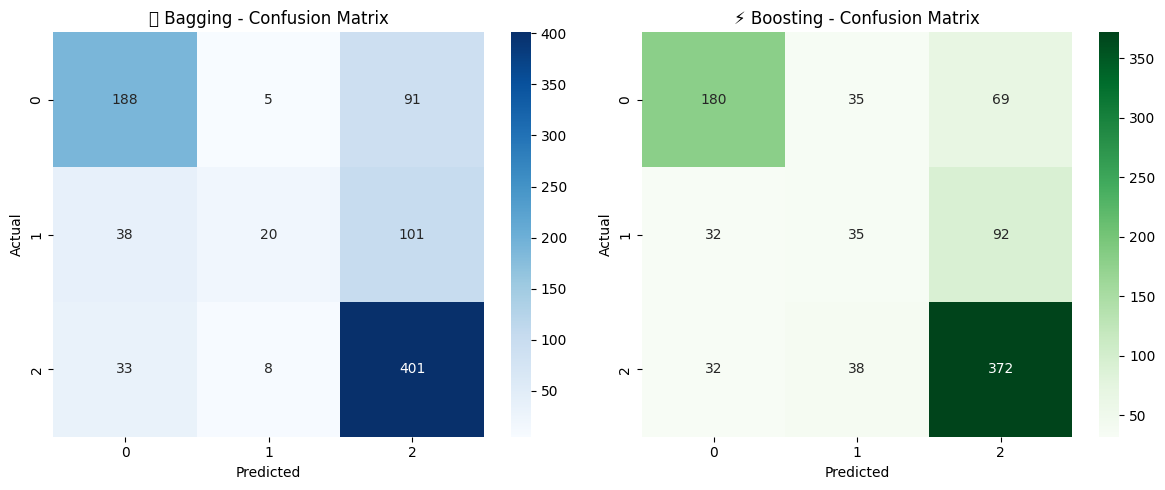

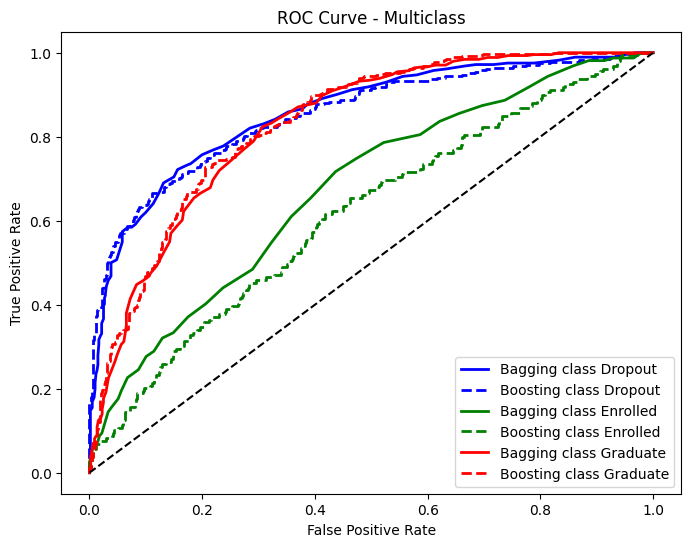

C:\Users\williaht\AppData\Local\Temp\ipykernel_14076\2054410406.py:142: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


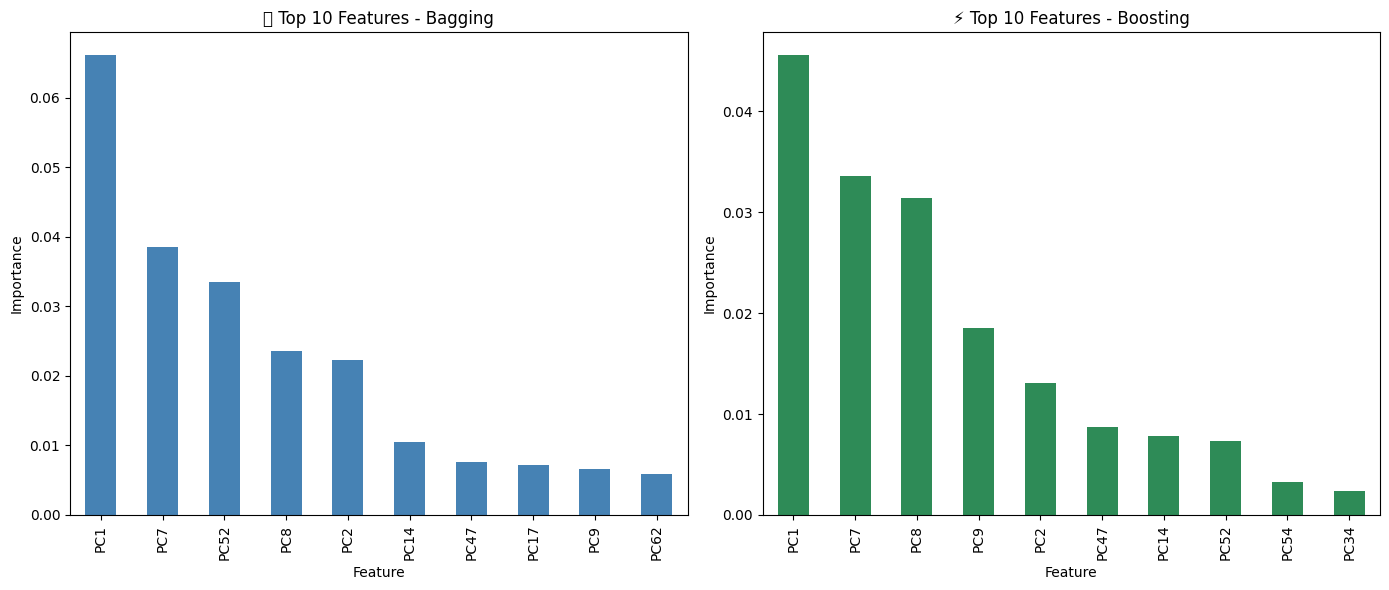


Partial Dependence for Boosting - Class Dropout


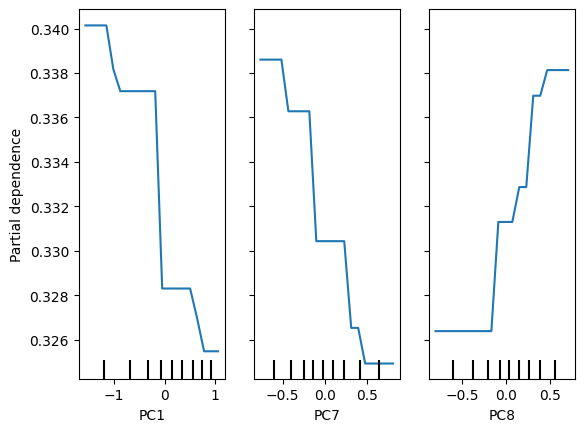


Partial Dependence for Boosting - Class Enrolled


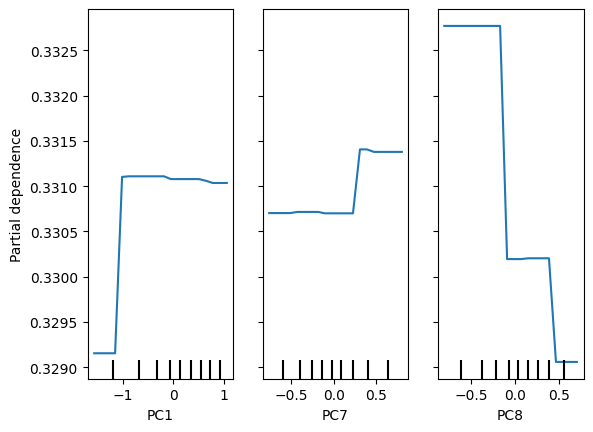


Partial Dependence for Boosting - Class Graduate


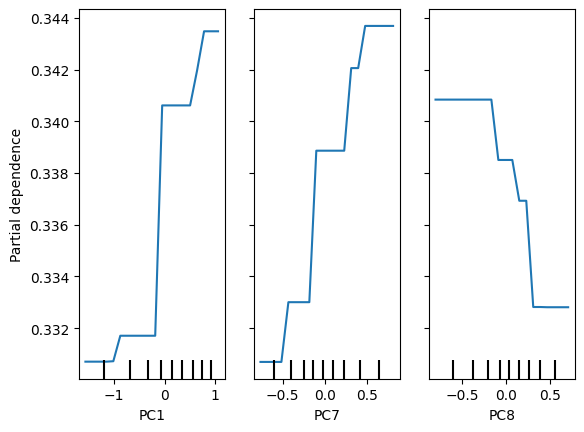

In [28]:
# 1️⃣ Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# 2️⃣ Load and prepare data
df = pd.read_csv("./student-graduation/graduation_dataset_processed.csv")

X = df.drop(columns=["Target"])
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️⃣ Define ensemble models

## Bagging
bagging_base = DecisionTreeClassifier(random_state=42)
bagging = BaggingClassifier(
    estimator=bagging_base,
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

## Boosting
boosting_base = DecisionTreeClassifier(max_depth=1, random_state=42)
boosting = AdaBoostClassifier(
    estimator=boosting_base,
    n_estimators=200,
    learning_rate=1.0,
    random_state=42
)

# 4️⃣ Train models
bagging.fit(X_train, y_train)
boosting.fit(X_train, y_train)

# 5️⃣ Predictions
y_pred_bagging = bagging.predict(X_test)
y_pred_boosting = boosting.predict(X_test)

# 6️⃣ Accuracy (train & test)
train_acc_bag = accuracy_score(y_train, bagging.predict(X_train))
train_acc_boost = accuracy_score(y_train, boosting.predict(X_train))
test_acc_bag = accuracy_score(y_test, y_pred_bagging)
test_acc_boost = accuracy_score(y_test, y_pred_boosting)

print(f"📦 Bagging - Train Accuracy: {train_acc_bag:.3f}, Test Accuracy: {test_acc_bag:.3f}")
print(f"⚡ Boosting - Train Accuracy: {train_acc_boost:.3f}, Test Accuracy: {test_acc_boost:.3f}")

# 7️⃣ Cross-validation
bagging_cv = cross_val_score(bagging, X, y, cv=5, scoring='accuracy', n_jobs=-1)
boosting_cv = cross_val_score(boosting, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f"Bagging CV Accuracy: {bagging_cv.mean():.3f} ± {bagging_cv.std():.3f}")
print(f"Boosting CV Accuracy: {boosting_cv.mean():.3f} ± {boosting_cv.std():.3f}")

# 8️⃣ Classification reports
print("\n--- Bagging Report ---")
print(classification_report(y_test, y_pred_bagging))
print("\n--- Boosting Report ---")
print(classification_report(y_test, y_pred_boosting))

# 9️⃣ Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_bag = confusion_matrix(y_test, y_pred_bagging)
cm_boost = confusion_matrix(y_test, y_pred_boosting)

sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('📦 Bagging - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_boost, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('⚡ Boosting - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 🔟 ROC Curve & AUC (for multiclass, one-vs-rest)
from sklearn.preprocessing import label_binarize
from itertools import cycle

classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_proba_bag = bagging.predict_proba(X_test)
y_proba_boost = boosting.predict_proba(X_test)

plt.figure(figsize=(8,6))
colors = cycle(['blue', 'green', 'red', 'orange', 'purple'])

for i, color in zip(range(len(classes)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_bag[:, i])
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Bagging class {classes[i]}')
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_boost[:, i])
    plt.plot(fpr, tpr, color=color, lw=2, linestyle='--', label=f'Boosting class {classes[i]}')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend()
plt.show()

# 1️⃣1️⃣ Feature Importance (Permutation)
bagging_perm = permutation_importance(
    bagging, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
boosting_perm = permutation_importance(
    boosting, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Bagging Importance': bagging_perm.importances_mean,
    'Boosting Importance': boosting_perm.importances_mean
}).set_index('Feature')

# Plot top 10 features for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
feat_imp['Bagging Importance'].sort_values(ascending=False).head(10).plot.bar(ax=axes[0], color='steelblue')
axes[0].set_title('📦 Top 10 Features - Bagging')
axes[0].set_ylabel('Importance')

feat_imp['Boosting Importance'].sort_values(ascending=False).head(10).plot.bar(ax=axes[1], color='seagreen')
axes[1].set_title('⚡ Top 10 Features - Boosting')
axes[1].set_ylabel('Importance')

plt.tight_layout()
plt.show()

# 1️⃣2️⃣ Partial Dependence Plots (top 3 boosting features)
top_features_boost = feat_imp['Boosting Importance'].sort_values(ascending=False).head(3).index.tolist()

# For multiclass AdaBoost, plot PDPs per class
for target_class in classes:
    print(f"\nPartial Dependence for Boosting - Class {target_class}")
    PartialDependenceDisplay.from_estimator(
        boosting,
        X_train,
        features=top_features_boost,
        target=target_class,
        kind='average',
        grid_resolution=20
    )
    plt.show()


📦 Bagging - Train Accuracy: 1.000, Test Accuracy: 0.688
⚡ Boosting - Train Accuracy: 0.742, Test Accuracy: 0.663
Bagging CV Accuracy: 0.688 ± 0.008
Boosting CV Accuracy: 0.684 ± 0.005

--- Bagging Report ---
              precision    recall  f1-score   support

     Dropout       0.73      0.66      0.69       284
    Enrolled       0.61      0.13      0.21       159
    Graduate       0.68      0.91      0.77       442

    accuracy                           0.69       885
   macro avg       0.67      0.56      0.56       885
weighted avg       0.68      0.69      0.65       885


--- Boosting Report ---
              precision    recall  f1-score   support

     Dropout       0.74      0.63      0.68       284
    Enrolled       0.32      0.22      0.26       159
    Graduate       0.70      0.84      0.76       442

    accuracy                           0.66       885
   macro avg       0.59      0.57      0.57       885
weighted avg       0.64      0.66      0.65       885



c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


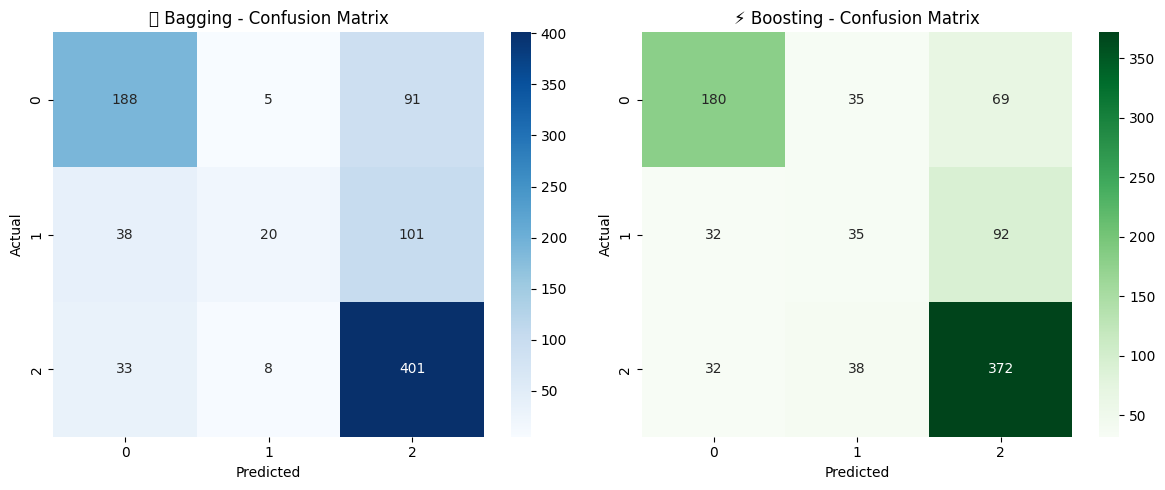

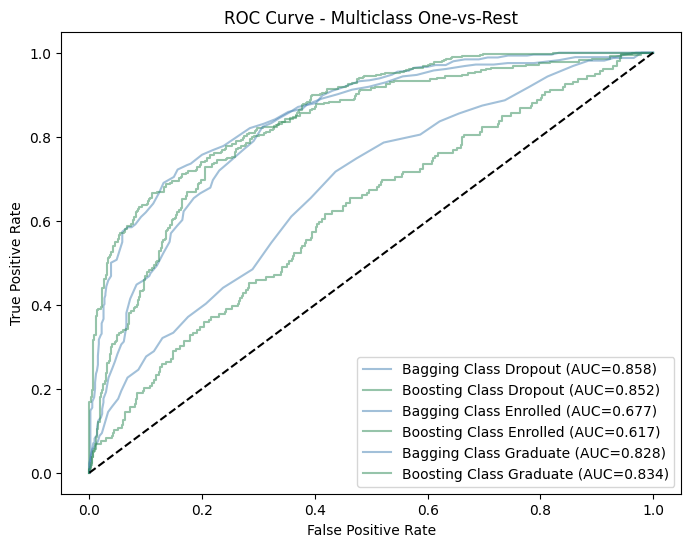

C:\Users\williaht\AppData\Local\Temp\ipykernel_14076\1473535021.py:138: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


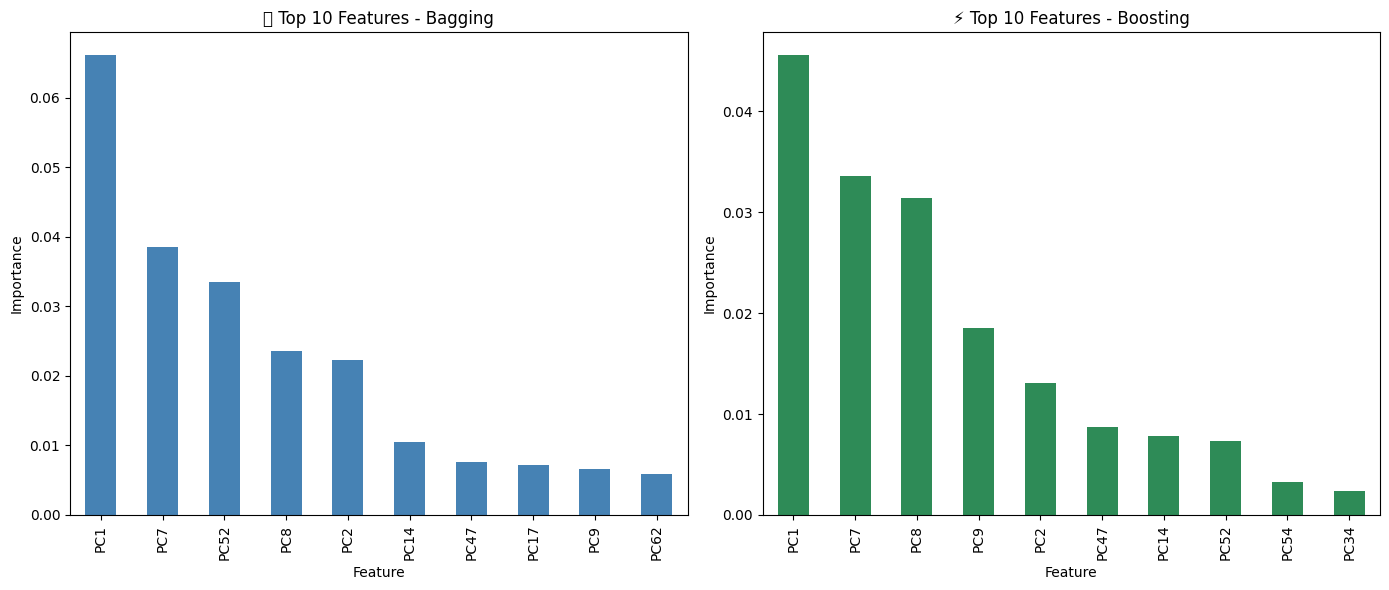


Partial Dependence - Class Dropout


C:\Users\williaht\AppData\Local\Temp\ipykernel_14076\1473535021.py:173: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


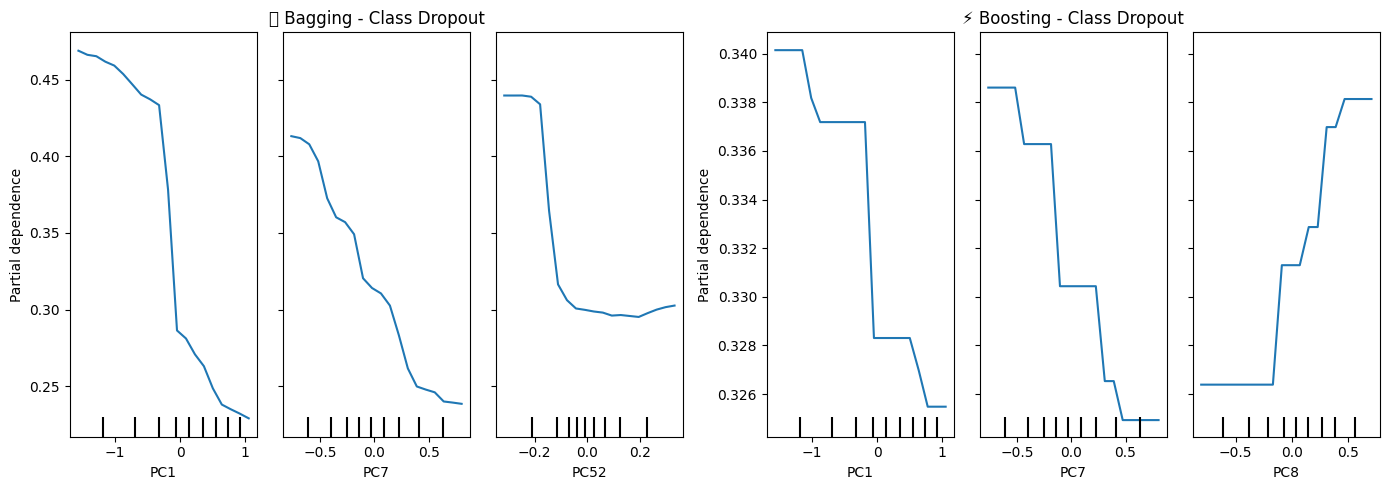


Partial Dependence - Class Enrolled


C:\Users\williaht\AppData\Local\Temp\ipykernel_14076\1473535021.py:173: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


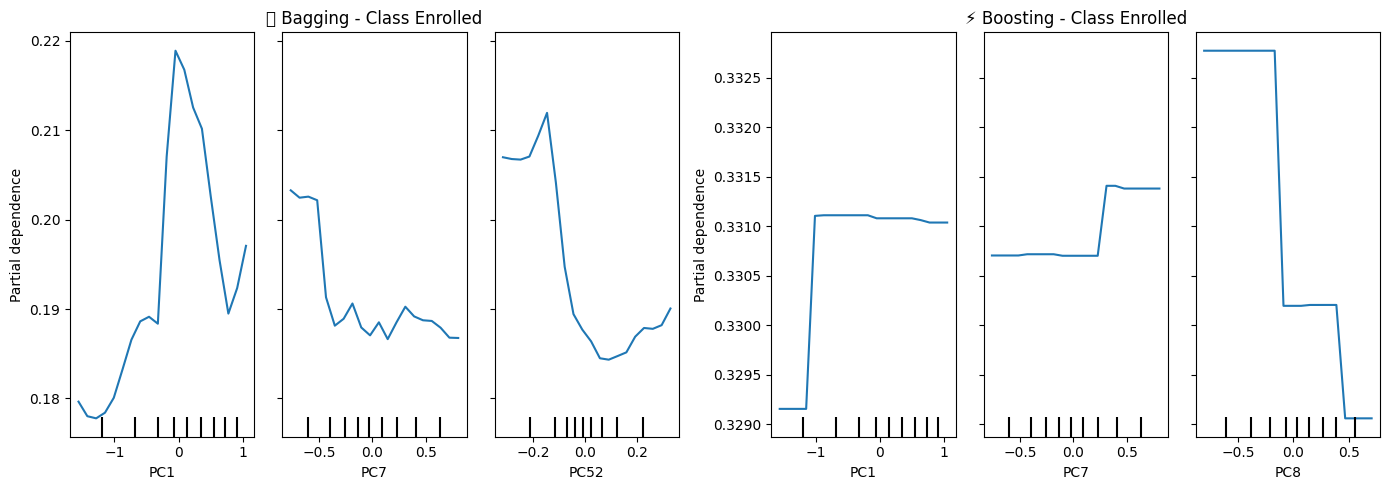


Partial Dependence - Class Graduate


C:\Users\williaht\AppData\Local\Temp\ipykernel_14076\1473535021.py:173: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\williaht\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


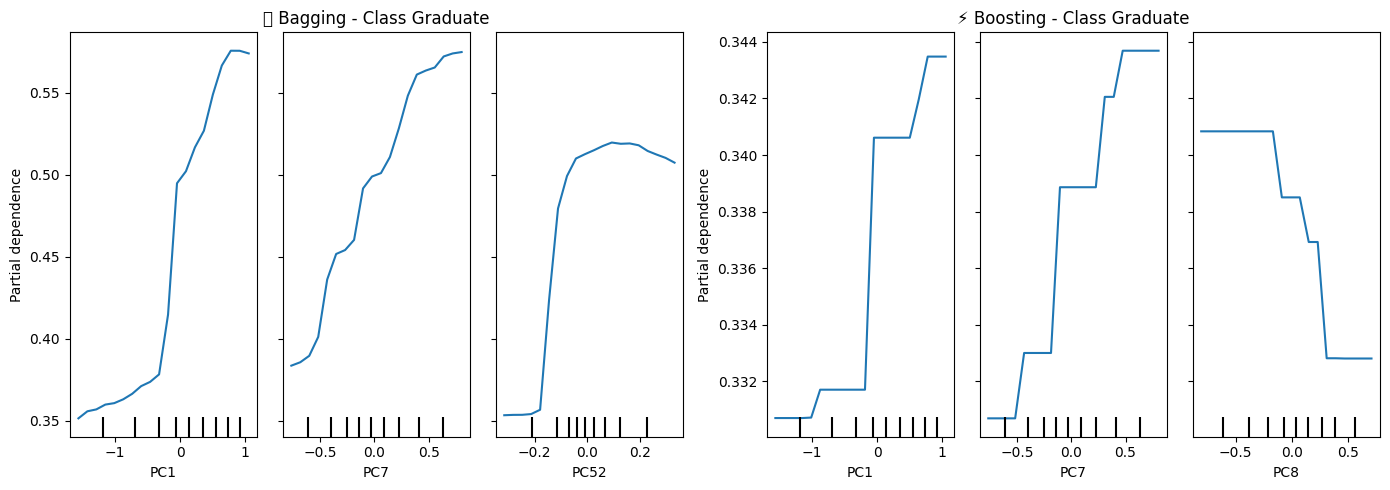

In [29]:
# 1️⃣ Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# 2️⃣ Load and prepare data
df = pd.read_csv("./student-graduation/graduation_dataset_processed.csv")

X = df.drop(columns=["Target"])
y = df["Target"]
classes = np.unique(y)  # List of target classes

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️⃣ Define ensemble models
## Bagging
bagging_base = DecisionTreeClassifier(random_state=42)
bagging = BaggingClassifier(
    estimator=bagging_base,
    n_estimators=100,
    max_samples=0.8,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

## Boosting
boosting_base = DecisionTreeClassifier(max_depth=1, random_state=42)
boosting = AdaBoostClassifier(
    estimator=boosting_base,
    n_estimators=200,
    learning_rate=1.0,
    random_state=42
)

# 4️⃣ Train models
bagging.fit(X_train, y_train)
boosting.fit(X_train, y_train)

# 5️⃣ Predictions
y_pred_bagging = bagging.predict(X_test)
y_pred_boosting = boosting.predict(X_test)

# 6️⃣ Accuracy (train & test)
train_acc_bag = accuracy_score(y_train, bagging.predict(X_train))
train_acc_boost = accuracy_score(y_train, boosting.predict(X_train))
test_acc_bag = accuracy_score(y_test, y_pred_bagging)
test_acc_boost = accuracy_score(y_test, y_pred_boosting)

print(f"📦 Bagging - Train Accuracy: {train_acc_bag:.3f}, Test Accuracy: {test_acc_bag:.3f}")
print(f"⚡ Boosting - Train Accuracy: {train_acc_boost:.3f}, Test Accuracy: {test_acc_boost:.3f}")

# 7️⃣ Cross-validation
bagging_cv = cross_val_score(bagging, X, y, cv=5, scoring='accuracy', n_jobs=-1)
boosting_cv = cross_val_score(boosting, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print(f"Bagging CV Accuracy: {bagging_cv.mean():.3f} ± {bagging_cv.std():.3f}")
print(f"Boosting CV Accuracy: {boosting_cv.mean():.3f} ± {boosting_cv.std():.3f}")

# 8️⃣ Classification reports
print("\n--- Bagging Report ---")
print(classification_report(y_test, y_pred_bagging))
print("\n--- Boosting Report ---")
print(classification_report(y_test, y_pred_boosting))

# 9️⃣ Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_bag = confusion_matrix(y_test, y_pred_bagging)
cm_boost = confusion_matrix(y_test, y_pred_boosting)

sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('📦 Bagging - Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_boost, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('⚡ Boosting - Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 🔟 ROC Curve & AUC (for multiclass, use one-vs-rest)
plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    # Bagging
    y_bin_test = (y_test == cls).astype(int)
    y_bin_pred_bag = bagging.predict_proba(X_test)[:, i]
    fpr_bag, tpr_bag, _ = roc_curve(y_bin_test, y_bin_pred_bag)
    plt.plot(fpr_bag, tpr_bag, label=f'Bagging Class {cls} (AUC={auc(fpr_bag, tpr_bag):.3f})', color='steelblue', alpha=0.5)
    
    # Boosting
    y_bin_pred_boost = boosting.predict_proba(X_test)[:, i]
    fpr_boost, tpr_boost, _ = roc_curve(y_bin_test, y_bin_pred_boost)
    plt.plot(fpr_boost, tpr_boost, label=f'Boosting Class {cls} (AUC={auc(fpr_boost, tpr_boost):.3f})', color='seagreen', alpha=0.5)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass One-vs-Rest')
plt.legend()
plt.show()

# 1️⃣1️⃣ Feature Importance (Permutation)
bagging_perm = permutation_importance(
    bagging, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
boosting_perm = permutation_importance(
    boosting, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Bagging Importance': bagging_perm.importances_mean,
    'Boosting Importance': boosting_perm.importances_mean
}).set_index('Feature')

# Plot top 10 features for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
feat_imp['Bagging Importance'].sort_values(ascending=False).head(10).plot.bar(ax=axes[0], color='steelblue')
axes[0].set_title('📦 Top 10 Features - Bagging')
axes[0].set_ylabel('Importance')

feat_imp['Boosting Importance'].sort_values(ascending=False).head(10).plot.bar(ax=axes[1], color='seagreen')
axes[1].set_title('⚡ Top 10 Features - Boosting')
axes[1].set_ylabel('Importance')

plt.tight_layout()
plt.show()

# 1️⃣2️⃣ Partial Dependence Plots - Bagging & Boosting Comparison
top_features_bag = feat_imp['Bagging Importance'].sort_values(ascending=False).head(3).index.tolist()
top_features_boost = feat_imp['Boosting Importance'].sort_values(ascending=False).head(3).index.tolist()

for target_class in classes:
    print(f"\nPartial Dependence - Class {target_class}")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bagging PDP
    PartialDependenceDisplay.from_estimator(
        bagging,
        X_train,
        features=top_features_bag,
        target=target_class,
        kind='average',
        ax=axes[0],
        grid_resolution=20
    )
    axes[0].set_title(f'📦 Bagging - Class {target_class}')
    
    # Boosting PDP
    PartialDependenceDisplay.from_estimator(
        boosting,
        X_train,
        features=top_features_boost,
        target=target_class,
        kind='average',
        ax=axes[1],
        grid_resolution=20
    )
    axes[1].set_title(f'⚡ Boosting - Class {target_class}')
    
    plt.tight_layout()
    plt.show()
